# 06 Models and Datasets

This notebook demonstrates the new `datasets` management layer and the `models_ext` module for SCS Curve Number and Unit Hydrograph modeling.

In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))

from hydrograph_lab.datasets import HydroDataset, ColumnRoles, HydroMetadata
from hydrograph_lab.models_ext import (
    SCSCurveNumberParams,
    scs_direct_runoff,
    SCSUnitHydrographParams,
    convolve_runoff_with_uh,
)
from hydrograph_lab.evaluation import evaluate_model
import matplotlib.pyplot as plt

## 1. Build Dataset
We load observed discharge and precipitation data from a CSV file.

In [2]:
# 1. Build dataset (obs + rainfall)
roles = ColumnRoles(obs_q="Q_obs", p="P")
meta = HydroMetadata(name="MyCatchment", area_km2=50.0)
ds = HydroDataset.from_csv("../event_data.csv", value_cols=["Q_obs", "P"], roles=roles, meta=meta)

print(f"Loaded dataset: {ds.meta.name}")
print(ds.data.head())

Loaded dataset: MyCatchment
                     Q_obs     P
datetime                        
2024-01-01 00:00:00    1.0   0.0
2024-01-01 01:00:00    1.0   0.0
2024-01-01 02:00:00    1.0   5.0
2024-01-01 03:00:00    1.1  10.0
2024-01-01 04:00:00    1.2  15.0


## 2. Compute Direct Runoff (SCS CN)
Calculate direct runoff depth from precipitation using the SCS Curve Number method.

In [3]:
# 2. Compute direct runoff via SCS CN
cn_params = SCSCurveNumberParams(CN=75.0, Ia_ratio=0.2)
Q_runoff = scs_direct_runoff(ds.get_precip(), cn_params)

print("Runoff computed.")
print(Q_runoff.head())

Runoff computed.
datetime
2024-01-01 00:00:00    0.0
2024-01-01 01:00:00    0.0
2024-01-01 02:00:00    0.0
2024-01-01 03:00:00    0.0
2024-01-01 04:00:00    0.0
Name: Q_runoff, dtype: float64


## 3. Route Runoff (SCS Unit Hydrograph)
Transform the runoff depth into a discharge hydrograph using the SCS Unit Hydrograph.

In [4]:
# 3. Route runoff through SCS UH
uh_params = SCSUnitHydrographParams(
    dt_hours=1.0,
    peak_time_hours=6.0,
    base_time_hours=36.0,
    uh_peak=1.0,  # not used in current simple normalization
)
Q_sim = convolve_runoff_with_uh(Q_runoff, uh_params)

print("Simulation complete.")
print(Q_sim.head())

Simulation complete.
datetime
2024-01-01 00:00:00    0.000000e+00
2024-01-01 01:00:00    0.000000e+00
2024-01-01 02:00:00   -4.625929e-19
2024-01-01 03:00:00   -4.625929e-19
2024-01-01 04:00:00    4.625929e-19
Name: Q_scs, dtype: float64


## 4. Update Dataset & Evaluate
Add the simulated discharge to the dataset and evaluate the model performance.

In [5]:
# 4. Add sim to dataset
ds.data["Q_sim"] = Q_sim

# 5. Evaluate
metrics = evaluate_model(
    obs_df=ds.data[["Q_obs"]],
    sim_df=ds.data[["Q_sim"]],
    obs_col="Q_obs",
    sim_col="Q_sim",
)

print("Model Evaluation Metrics:")
print(metrics)

Model Evaluation Metrics:
{'NSE': np.float64(-1.8413086752327277), 'KGE': -0.4996802565584124, 'RMSE': 3.214451000688491, 'Bias': np.float64(-99.87649192992288), 'R': 0.4962552302935509, 'logNSE': nan}


## 5. Visualization
Plot the observed vs simulated discharge.

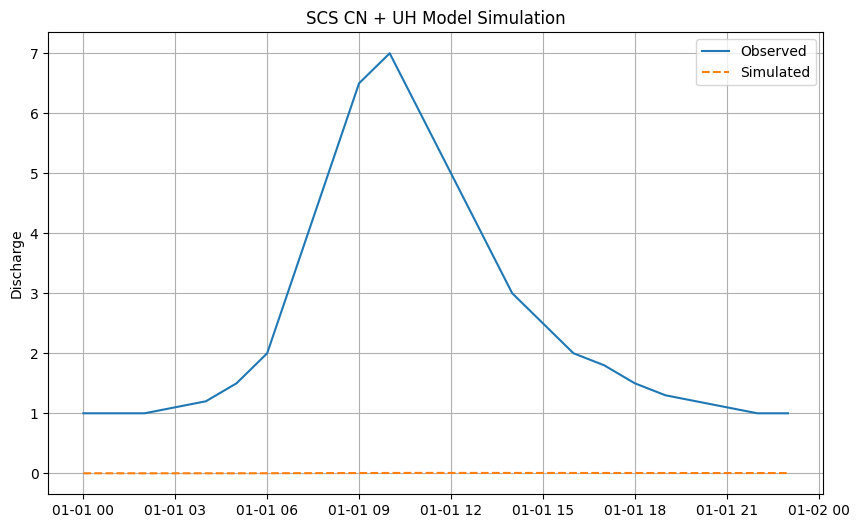

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(ds.data.index, ds.get_obs(), label="Observed")
plt.plot(ds.data.index, ds.get_sim(), label="Simulated", linestyle="--")
plt.ylabel("Discharge")
plt.title("SCS CN + UH Model Simulation")
plt.legend()
plt.grid(True)
plt.show()